# PyMODSim Demo

Author: Arslan Ali Syed

Easily simulate agent-based mobility-on-demand (MOD) with few lines of code anywhere in the world using OpenStreetMap network.

This notebook provides a quick demo of some of the key features of PyMODSim including how to:
- prepare customer data for MOD simulation
- download and prepare an OpenStreetMap based router
- setup a basic dynamic ride sourcing simulation
- analyze results of the simulation

In [15]:
import pymodsim
import osmnx as ox
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
print("osmnx: ", ox.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("pymodsim: ", pymodsim.__version__)

osmnx:  0.11.4
numpy:  1.19.4
pandas:  1.1.4
pymodsim:  0.0.1


In [3]:
# Example customer data set. PyMODSim expects the column names of the data set to be same as below.

user_data = pd.read_csv("data\\yellow_taxi_04_april_2016_6am_to_12pm.csv")
user_data.head()

,Unnamed: 0,pickup_time,dropoff_time,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,pickup_node,dropoff_node
0,1015227,2016-04-04 06:00:02,2016-04-04 06:06:45,1,-73.968530,40.754658,-73.987400,40.752174,6175849564,42428264
1,1015228,2016-04-04 06:00:03,2016-04-04 06:04:51,2,-73.967640,40.756035,-73.984886,40.732370,42442955,42440737
2,1015229,2016-04-04 06:00:03,2016-04-04 06:08:49,1,-74.005875,40.717600,-73.972990,40.759632,42448171,596775900
3,1015230,2016-04-04 06:00:05,2016-04-04 06:17:52,1,-73.989400,40.757680,-73.955000,40.785840,5849918504,7093620701
4,1015231,2016-04-04 06:00:06,2016-04-04 06:04:54,1,-73.991340,40.749910,-73.981750,40.757812,42439440,42430350


# Setup and run simulation

C:\Installed_Programs\MiniConda3\envs\pymod_test\lib\site-packages\osmnx\projection.py:72: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf.crs = crs


Total nodes in the network:  4580


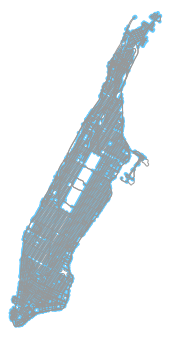

(<Figure size 273.328x432 with 1 Axes>, <AxesSubplot:>)

In [4]:
# The simulation first needs a city network which can be downloaded using osmnx library.

manhattan_network = ox.graph_from_place('Manhattan, New York City, New York, USA', network_type='drive', simplify=True)
print("Total nodes in the network: ", len(manhattan_network.nodes))
ox.plot_graph(manhattan_network)

In [5]:
# The city network is used by a networkx graph based router. The router provides the travel times and distances to the simulator. 
# The travel time and distance matrices is calculated in advance by the router for the whole network. The calculated matrices are saved and reused for later simulations.

from pymodsim.router.osmnx_graph_router import OSMNxGraphRouter

# router = OSMNxGraphRouter(manhattan_network, missing_speed=40)

Removing not reachable nodes from osmnx graph
Total removed: 86 out of 4580
New Number of nodes: 4494
Removing multiple edges between nodes from the osmnx graph.
Total edges removed=35


C:\Installed_Programs\MiniConda3\envs\pymod_test\lib\site-packages\osmnx\projection.py:168: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  gdf_nodes.crs = G_proj.graph['crs']


could not find files for precalculated matrices for OSMNxGraphRouter
calculating the time and distance matrices
calculating matrices in 23x23 blocks of 200 size each



writing the calculated matrices to files


Total nodes in the network:  4494


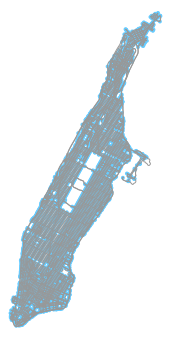

(<Figure size 201.851x432 with 1 Axes>, <AxesSubplot:>)

In [6]:
# Since the vehicles traverse the edges of the directed network graph, any node that has zero in- or out-degree is recursively removed. This makes sure that a vehicle does not get stucked at some node. 
# This little bit changes the shape of the network as shown below. In future, this can be resolved by manually adding edges to the network.

print("Total nodes in the network: ", len(router.osmnx_graph_utm))
ox.plot_graph(router.osmnx_graph_utm)

In [25]:
# The above processed matrices and graph are saved in the folder "processed_osmnx_router_data". A osmnx router can be loaded from the saved information using the arguement "load_processed", as shown below:

router = OSMNxGraphRouter(load_processed=True)

loading processed graphs from folder processed_osmnx_router_data
loaded time and distance matrices from available files


In [7]:
# The simulator uses the data reader for getting dynamic customer information from the user csv file. The simulation period is also set up inside the data reader.

from pymodsim.data_readers import reader_class

file = "data\\yellow_taxi_04_april_2016_6am_to_12pm.csv"
startdt = "2016-04-04 06:00:02"
enddt = "2016-04-04 10:00:00"
data_reader = reader_class.DataReader(file, router, startdt, enddt)

In [10]:
# Finally the simulator is set up with the router and data reader.
# The initial positions of the vehicles are generated by randomly taking the destination positions from the provided data set

from pymodsim.simulator import simulator

nr_vehicles = 100
simulator = simulator.SimulatorClass(nr_vehicles, data_reader)
history = simulator.run()

# Analyze results

In [9]:
# The history object containts the necessary information for the post simulation analysis

history.summary

OrderedDict([('Total Vehicles', 20),
             ('Total Reqs', 59744),
             ('Total Expired', 58809),
             ('Total Served', 935),
             ('Total Service Distance', 0),
             ('Total Empty Distance', 292666.64199999993),
             ('Total Distance', 2715136.5649999995)])

In [19]:
# Get the dataframe for time plots

realtime_df = history.get_realtime_info_df()
realtime_df.head()

,TimeDelta,ActualTime,ScheduledReqs,ServingReqs,ExpiredReqs,UnscheduledReqs,TotalReqs,ServiceVehicleDistance,TotalEmptyDistance,TotalVehicleDistance,PickUpDelay
ActualTime,,,,,,,,,,,
2016-04-04 05:59:32,0:00:30,2016-04-04 05:59:32,0,0,0,0,0,0,0.000,0.000,0.000000
2016-04-04 06:00:02,0:01:00,2016-04-04 06:00:02,0,0,0,0,0,0,0.000,0.000,0.000000
2016-04-04 06:00:32,0:01:30,2016-04-04 06:00:32,0,38,0,0,38,0,0.000,0.000,0.000000
2016-04-04 06:01:02,0:02:00,2016-04-04 06:01:02,3,75,0,0,78,0,1702.813,1702.813,0.413328
2016-04-04 06:01:32,0:02:30,2016-04-04 06:01:32,20,91,4,0,115,0,11080.923,11080.923,0.886026


<AxesSubplot:xlabel='ActualTime'>

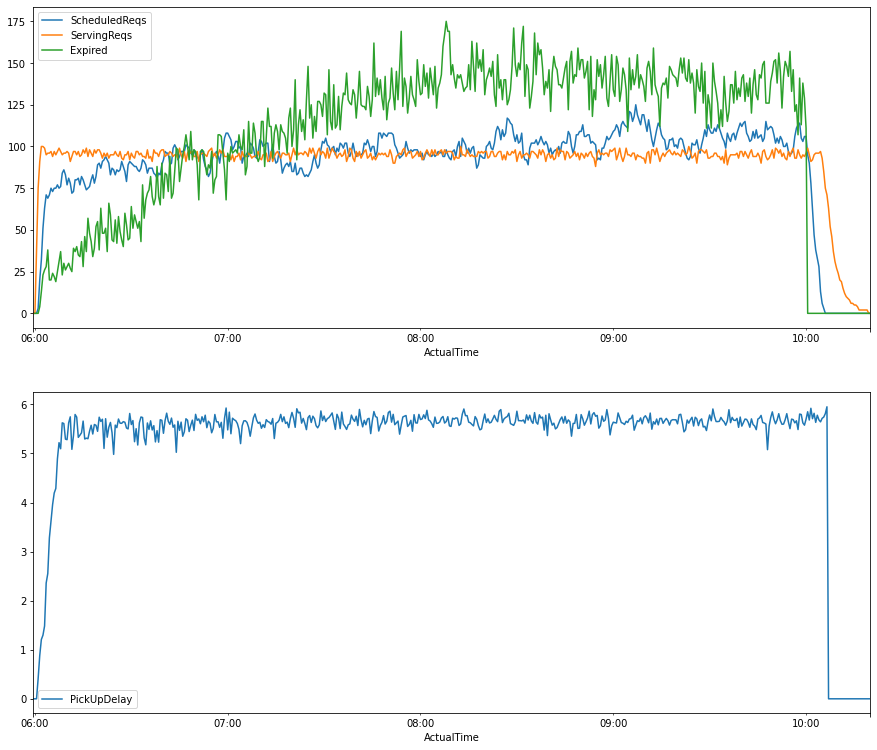

In [24]:
fig, axes = plt.subplots(2,1, figsize=(15, 13))

realtime_df["Expired"] = realtime_df["ExpiredReqs"].diff()
realtime_df.plot(y=["ScheduledReqs", "ServingReqs", "Expired"], ax=axes[0])
realtime_df.plot(y=["PickUpDelay"], ax=axes[1])